In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [2]:
tfd = tfp.distributions
tfb = tfp.bijectors

sns.set()

In [3]:
negloglik = lambda y, rv_y: -rv_y.log_prob(y)

# Synthetic Dataset

In [34]:
def cp_dataset(n=150, n_tst=150,beta=2):
    # to allow for reproducibility 
    np.random.seed(43)
    # We're making the picking the input features randomly.
    x = np.random.rand(n)
    
    #Let's make the errors heterosckedastic
    eps = np.sqrt(x)*np.random.randn(n)
    
    y = (beta*x)+ eps
    x = x[:, np.newaxis]
    
    # we're making the test inputs to be deterministic, probably different from the 
    # training input features
    x_tst = np.linspace(np.min(x),np.max(x), num=n_tst).astype(np.float32)
    x_tst = x_tst[:, np.newaxis]
    return y, x, x_tst

y_syn_ds, x_syn_ds, x_tst_syn_ds = cp_dataset()

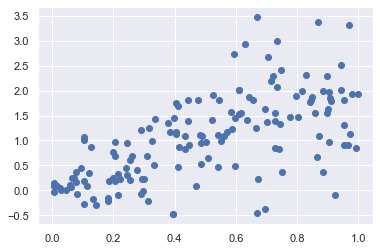

In [35]:
plt.scatter(x_syn_ds,y_syn_ds)
plt.show()

# Building the model for Synth DS

In [13]:
x_tst_syn_ds.shape

(150, 1)

In [40]:
# Build model.
model_syn_ds= tf.keras.Sequential([
    tf.keras.layers.Dense(2, input_shape=(1,),name="Dense"),
    tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t[:,:1], scale=t[:, 1:]),
                                  convert_to_tensor_fn=tfd.Distribution.sample,
                                  name="Distribution")])

In [41]:
# compiling the model
model_syn_ds.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)

In [42]:
model_syn_ds.summary()

model_syn_ds.fit(x_syn_ds, y_syn_ds, epochs=1000, verbose=False);

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense (Dense)               (None, 2)                 4         
                                                                 
 Distribution (DistributionL  ((None, 1),              0         
 ambda)                       (None, 1))                         
                                                                 
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


In [48]:
try_point=np.array([[0]])
for _ in range(5):
    print(model_syn_ds.predict(try_point))

[[0.06563904]]
[[0.10734452]]
[[0.04005437]]
[[0.27677578]]
[[0.53991]]


Notice that whenever I run my model on a constant, it will always predict a different value. 
This is the main difference between probabilistic programming and deterministic programming.

We now have a model which acts like a distribution!

In [45]:
model_syn_ds.weights

[<tf.Variable 'Dense/kernel:0' shape=(1, 2) dtype=float32, numpy=array([[2.034828  , 0.83319634]], dtype=float32)>,
 <tf.Variable 'Dense/bias:0' shape=(2,) dtype=float32, numpy=array([0.02233634, 0.23062891], dtype=float32)>]

In [46]:
model_cp_ds.weights[1][0],model_cp_ds.weights[1][1]

(<tf.Tensor: shape=(), dtype=float32, numpy=0.029301262>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.14929952>)

In [44]:
# Do inference.
yhat_syn_ds = model_syn_ds(x_tst_syn_ds)


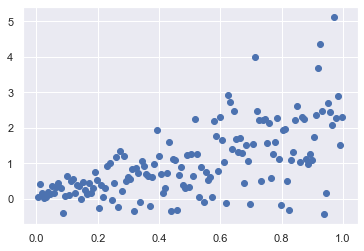

In [47]:
plt.scatter(x_tst_cp_ds,yhat_cp_ds.sample())
plt.show()